In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

C:\Users\Caspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [10]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self, input_channels= 4):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Average the weights of the first convolution but retain 3 input layers
        weights = self.model.conv1.weight.clone()
        weights_avg = torch.mean(weights, dim=1, keepdim=True)
    
        weights = torch.cat([weights_avg for _ in range(input_channels)], dim=1)
        self.model.conv1.weight = torch.nn.Parameter(weights)
        self.model.conv1.in_channels = input_channels
        
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)            
        self.model.layer3[-1].register_forward_hook(hook) 

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps
        patch = patch.reshape(patch.shape[1], -1).T   # Craete a column tensor

        return patch

In [17]:
from src.Dataloader import Dataloader

dataset_path = 'Datasets/Dataset004'
dataset = Dataloader(dataset_path)
train_loader, val_loader, test_loader = dataset.load_train_vali_test_dataloaders_with_n_images(n_images=4, trainSplit=0.8, BS=1)
            
image = train_loader.dataset[0]
print(type(image))
image = image.unsqueeze(0).cuda()
# image = transform(image).unsqueeze(0).cuda()

backbone = resnet_feature_extractor().cuda()
feature = backbone(image)

# print(backbone.features[0].shape)
# print(backbone.features[1].shape)

print(feature.shape)

# plt.imshow(image[0].permute(1,2,0))

<class 'torch.Tensor'>
torch.Size([784, 1536])


In [19]:
memory_bank =[]


for image in tqdm(train_loader.dataset):

    with torch.no_grad():
        data = image.unsqueeze(0).cuda()
        features = backbone(data)
        memory_bank.append(features.cpu().detach())

memory_bank = torch.cat(memory_bank,dim=0).cuda()

100%|██████████| 160/160 [00:02<00:00, 67.22it/s]


In [21]:
y_score=[]

for image in tqdm(train_loader.dataset):
    data = image.unsqueeze(0).cuda()
    with torch.no_grad():
        features = backbone(data)
    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1) 
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28) 

    y_score.append(s_star.cpu().numpy())

100%|██████████| 160/160 [00:18<00:00,  8.44it/s]


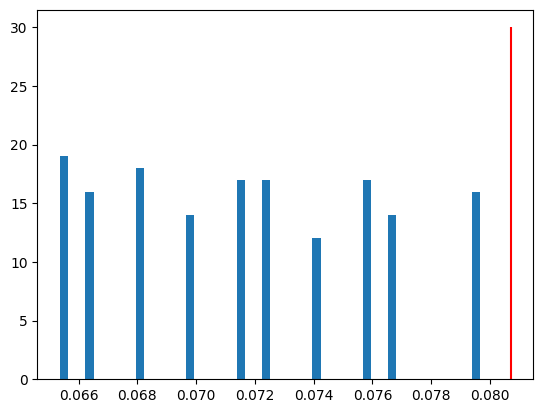

In [22]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [24]:
y_score = []
y_true=[]


# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = inputs.cuda()
#         outputs = model(inputs)
#         mse = criterion(outputs, inputs).item()

#         y_true.extend(labels.numpy())
#         y_pred.extend([1 if mse > threshold else 0] * len(labels))


for image, label in test_loader:
    with torch.no_grad():
        test_image = image.cuda()
        features = backbone(test_image)

    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1) 
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28) 

    y_score.append(s_star.cpu().numpy())
    y_true.append(label)

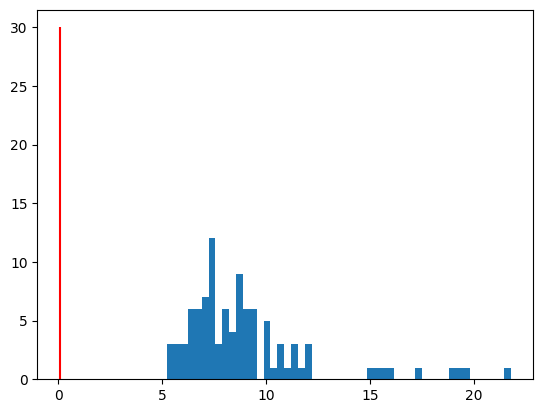

In [25]:
# plotting the y_score values which do not belong to 'good' class

y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

torch.Size([4, 224, 224])


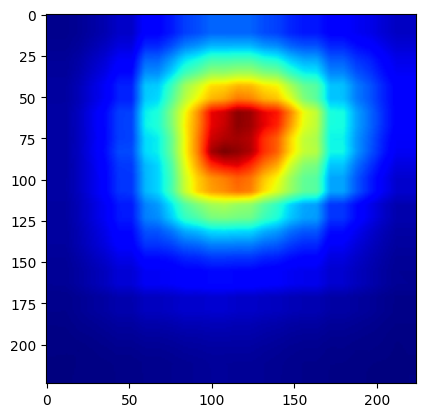

In [30]:
test_image, _ = test_loader.dataset[0]
print(test_image.shape)
features = backbone(test_image.unsqueeze(0).cuda())

distances = torch.cdist(features, memory_bank, p=2.0)
dist_score, dist_score_idxs = torch.min(distances, dim=1) 
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.cpu().squeeze(), cmap='jet')

AUC-ROC Score: 1.0


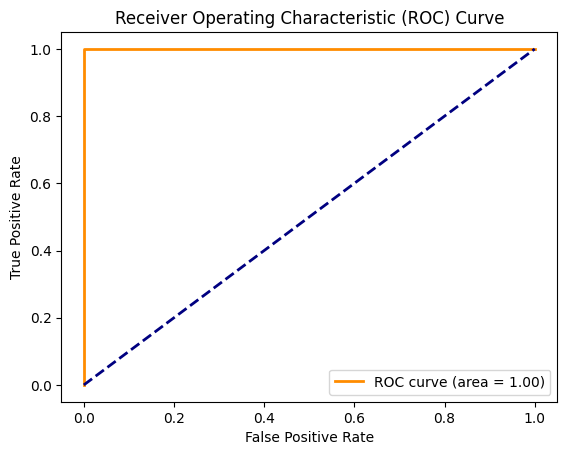

best_threshold = 5.255112648010254


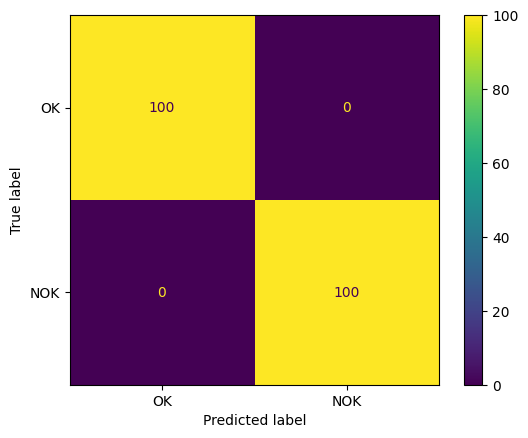

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

In [ ]:
import cv2, time
from IPython.display import clear_output

backbone.eval()

test_path = Path('carpet/test')

for image, label in tqdm(test_loader):
            
    test_image = image.cuda()
    
    with torch.no_grad():
        features = backbone(test_image)
    # Forward pass
    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1) 
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28) 
    segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                segm_map,
                size=(224, 224),
                mode='bilinear'
            ).cpu().squeeze().numpy()
    
    y_score_image = s_star.cpu().numpy()
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']


    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
    plt.title(f'fault type: {fault_type}')

    plt.subplot(1,3,2)
    heat_map = segm_map
    plt.imshow(heat_map, cmap='jet',vmin=best_threshold, vmax=best_threshold*2) 
    plt.title(f'Anomaly score: {y_score_image / best_threshold:0.4f} || {class_label[y_pred_image]}')

    plt.subplot(1,3,3)
    plt.imshow((heat_map > best_threshold*1.25), cmap='gray')
    plt.title(f'segmentation map')
    
    plt.show()

    time.sleep(0.05)
    clear_output(wait=True)